In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics
from tensorflow.keras.callbacks import TensorBoard


import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

import gc

%config ZMQInteractiveShell.ast_node_interactivity='all'

## 更新内容

- load_data()中在处理数据时，calendar、prices数据将限制时间截止日期为date(2016, 4, 24)，改为不限制截止日期
- 将prices数据改为外延特征，改为：xPrices = prices_tmp[pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28).date].values
- 增加外延特征（timesteps+28）：snap_CA, snap_TX, snap_WI, event_name_1_num, event_name_2_num


In [2]:
# 开始结束日期（用于训练数据初步筛选）
START_DATE = date(2013, 1, 1)
END_DATE = date(2016, 4, 24)

def read_sales(start_date=START_DATE, end_date=END_DATE):
    raw_day_cols = [i for i in range(1,1913+1)]
    date_cols = pd.date_range(start='1/29/2011', periods=1913).date
    raw_mapdate_dict = dict(zip(date_cols, raw_day_cols))
    start_index =  raw_mapdate_dict[start_date]
    end_index =  raw_mapdate_dict[end_date]
    cat_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    num_cols = ['d_'+ str(i) for i in range(start_index, end_index+1)]
    SALES_DTYPES = dict(zip(cat_cols, ["category"]*len(cat_cols)))
    SALES_DTYPES.update(dict(zip(num_cols, ["float32"]*len(num_cols))))
    
    dt = pd.read_csv( "../data/sales_train_validation.csv", 
                     usecols=cat_cols + ['d_'+ str(i) for i in range(start_index, end_index+1)],
                     dtype = SALES_DTYPES)
    for i in num_cols:
        dt[i] = np.log1p(dt[i])
        
    dt.columns = cat_cols + list(pd.date_range(start=start_date, end=end_date).date)
    dt.index = dt.id
    dt.drop(columns=["id"], inplace=True)

    return dt


def load_data(start_date=START_DATE, end_date=END_DATE):
    
    print('==============================> dt')
    dt_time = datetime.now()
    dt = read_sales()
    print(datetime.now()-dt_time)
    
    
    PRICE_DTYPES = {
                    "wm_yr_wk": "int16",
                    "sell_price":"float32" 
                   }
    prices = pd.read_csv("../data/sell_prices.csv", dtype = PRICE_DTYPES)
    
    CALEN_DTYPES={"event_name_1": "category", 
                "event_name_2": "category", 
                "event_type_1": "category", 
                "event_type_2": "category", 
                "weekday": "category", 
                'wm_yr_wk': 'int16', 
                "wday": "int16",
                "month": "int16", 
                "year": "int16", 
                "snap_CA": "int16", 
                'snap_TX': 'int16', 
                'snap_WI': 'int16' 
               }
    calendar = pd.read_csv("../data/calendar.csv", dtype = CALEN_DTYPES, parse_dates=["date"])
    calendar["date"] = calendar["date"].apply(lambda x: x.date())
    ############################################################### wanping7调整于2020-05-19
#     calendar = calendar[(calendar.date>=start_date) & (calendar.date<=end_date)]
    calendar = calendar[(calendar.date>=start_date)]

    for i in ["event_name_1", "event_name_2"]:
        print(i)
        name = i + "_num"
        calendar[name] = 1
        calendar.loc[calendar[i].isna(), name] = 0
        calendar[[name]] = calendar[[name]].astype('int16')
        calendar.drop(columns=[i], inplace=True)

    print('==============================> prices')
    prices_time = datetime.now()
    prices["id"] = prices["item_id"] + "_" + prices["store_id"] + "_validation"
    prices.drop(columns=["item_id", "store_id"], inplace=True)
    prices = calendar.merge(prices, how="left", on=["wm_yr_wk"])
    ############################################################### wanping7调整于2020-05-19
#     prices = prices.loc[(prices.date>=start_date) & (prices.date<=end_date), ["id", "date", "sell_price"]]
    prices = prices.loc[(prices.date>=start_date), ["id", "date", "sell_price"]]
    print(prices.shape)
#     prices = prices.set_index(["id", "date"])[["sell_price"]].unstack(level=-1).fillna(False)
    
    index = [list(prices.id), list(prices.date)]
    index = pd.MultiIndex.from_arrays(index)
    prices = pd.Series(list(prices.sell_price), index=index)
    prices = prices.unstack()
    print('..................................')


#     prices.columns = pd.Series(prices.columns.get_level_values(1)).apply(lambda x: x.date())
#     prices.reset_index(inplace=True)
#     print('..................................')
#     #
#     prices.index = prices.id
#     prices.drop(columns=["id"], inplace=True)
    prices = prices.reindex(dt.index).fillna(0)
    print(datetime.now()-prices_time)
    

    print('==============================> calendar转置')
    calendar_time = datetime.now()
    # calendar转置like dt
    row_names = calendar.date.values
    calendar.drop(columns=["date"], inplace=True)
    calendar = calendar.T
    calendar.columns = row_names
    calendar = calendar.loc[["snap_CA", "snap_TX", "snap_WI", "event_name_1_num", "event_name_2_num"],:]
    calendar.fillna(0, inplace=True)
    print(datetime.now()-calendar_time)
    
    return dt, calendar, prices

In [3]:
# dt, calendar, prices = load_data()
# dt.to_pickle('../data/dt.pkl')
# calendar.to_pickle('../data/calendar.pkl')
# prices.to_pickle('../data/prices.pkl')

In [4]:
dt = pd.read_pickle('../data/dt.pkl')
calendar = pd.read_pickle('../data/calendar.pkl')
prices = pd.read_pickle('../data/prices.pkl')

In [5]:
dt.head(2)
calendar.head(2)
prices.head(2)

,item_id,dept_id,cat_id,store_id,state_id,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.000000,0.0,0.0,0.0,0.0,...,0.693147,1.386294,0.0,0.693147,0.693147,0.693147,1.386294,0.0,0.693147,0.693147
HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.693147,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.000000


,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19
snap_CA,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
snap_TX,1,0,1,0,1,1,1,0,1,0,...,0,1,1,1,0,1,0,0,0,0


,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38
HOBBIES_1_002_CA_1_validation,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97


In [6]:
len(dt.item_id.unique())
len(dt.dept_id.unique())
len(dt.cat_id.unique())
len(dt.store_id.unique())
len(dt.state_id.unique())

3049

7

3

10

3

# 构建特征

In [7]:
# Create validation and test data
def create_dataset(dt, calendar, prices, timesteps, first_pred_start, 
                   is_train=True, aux_as_tensor=False, reshape_output=0):
    encoder = LabelEncoder()
    dt["item_id"] = encoder.fit_transform(dt["item_id"].values)
    dt["dept_id"] = encoder.fit_transform(dt["dept_id"].values)
    dt["cat_id"] = encoder.fit_transform(dt["cat_id"].values)
    dt["store_id"] = encoder.fit_transform(dt["store_id"].values)
    dt["state_id"] = encoder.fit_transform(dt["state_id"].values)
    cat_features = dt[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].values
    
    tmp = dt[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
    item_group_mean = dt.groupby('item_id').mean()
    item_group_mean = tmp.merge(item_group_mean, how="left", on="item_id")
    dept_group_mean = dt.groupby('dept_id').mean()
    dept_group_mean = tmp.merge(dept_group_mean, how="left", on="dept_id")
    cat_group_mean = dt.groupby('cat_id').mean()
    cat_group_mean = tmp.merge(cat_group_mean, how="left", on="cat_id")
    store_group_mean = dt.groupby('store_id').mean()
    store_group_mean = tmp.merge(store_group_mean, how="left", on="store_id")
    state_group_mean = dt.groupby('state_id').mean()
    state_group_mean = tmp.merge(state_group_mean, how="left", on="state_id")

    return create_dataset_part(dt, calendar, prices, cat_features, item_group_mean, dept_group_mean, cat_group_mean, store_group_mean, 
                                state_group_mean, timesteps, first_pred_start, reshape_output, aux_as_tensor, is_train)

# Create train data
def train_generator(dt, calendar, prices, timesteps, first_pred_start,
    n_range=1, day_skip=7, is_train=True, batch_size=2000, aux_as_tensor=False, reshape_output=0, first_pred_start_2016=None):
    encoder = LabelEncoder()
    dt["item_id"] = encoder.fit_transform(dt["item_id"].values)
    dt["dept_id"] = encoder.fit_transform(dt["dept_id"].values)
    dt["cat_id"] = encoder.fit_transform(dt["cat_id"].values)
    dt["store_id"] = encoder.fit_transform(dt["store_id"].values)
    dt["state_id"] = encoder.fit_transform(dt["state_id"].values)
    cat_features = dt[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].values
    
    tmp = dt[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
    item_group_mean = dt.groupby('item_id').mean()
    item_group_mean = tmp.merge(item_group_mean, how="left", on="item_id")
    dept_group_mean = dt.groupby('dept_id').mean()
    dept_group_mean = tmp.merge(dept_group_mean, how="left", on="dept_id")
    cat_group_mean = dt.groupby('cat_id').mean()
    cat_group_mean = tmp.merge(cat_group_mean, how="left", on="cat_id")
    store_group_mean = dt.groupby('store_id').mean()
    store_group_mean = tmp.merge(store_group_mean, how="left", on="store_id")
    state_group_mean = dt.groupby('state_id').mean()
    state_group_mean = tmp.merge(state_group_mean, how="left", on="state_id")

    while 1:
        date_part = np.random.permutation(range(n_range))
#         if first_pred_start_2016 is not None:
#             range_diff = (first_pred_start - first_pred_start_2016).days / day_skip
#             date_part = np.concat([date_part, np.random.permutation(range(range_diff, int(n_range/2) + range_diff))])
        N_SAMPLES = dt.shape[0]
        for i in date_part:
            keep_idx = np.random.permutation(N_SAMPLES)[:batch_size]
            dt_tmp = dt.iloc[keep_idx,:]
            prices_tmp = prices.iloc[keep_idx,:]
            cat_features_tmp = cat_features[keep_idx]
            item_group_mean_tmp = item_group_mean.iloc[keep_idx,:]
            dept_group_mean_tmp = dept_group_mean.iloc[keep_idx,:]
            cat_group_mean_tmp = cat_group_mean.iloc[keep_idx,:]
            store_group_mean_tmp = store_group_mean.iloc[keep_idx,:]
            state_group_mean_tmp = state_group_mean.iloc[keep_idx,:]

            pred_start = first_pred_start - timedelta(days=int(day_skip*i))

            # 生成一批随机子集数据。同一批次中的所有数据都在同一时期。
            yield create_dataset_part(dt_tmp, calendar, prices_tmp, cat_features_tmp, item_group_mean_tmp, 
                                      dept_group_mean_tmp, cat_group_mean_tmp, store_group_mean_tmp, state_group_mean_tmp, 
                                      timesteps, pred_start, reshape_output, aux_as_tensor, is_train=True)

            gc.collect()

In [8]:
def create_xy_span(dt, pred_start, timesteps, is_train=True, shift_range=0):
    X = dt[pd.date_range(pred_start-timedelta(days=timesteps), pred_start-timedelta(days=1)).date].values
    if is_train: y = dt[pd.date_range(pred_start, periods=28).date].values
    else: y = None
    return X, y

In [9]:
def create_dataset_part(dt_tmp, calendar, prices_tmp, cat_features_tmp, item_group_mean_tmp, 
                        dept_group_mean_tmp, cat_group_mean_tmp, store_group_mean_tmp, state_group_mean_tmp, 
                        timesteps, pred_start, reshape_output, aux_as_tensor, is_train, weight=False):


    X, y = create_xy_span(dt_tmp, pred_start, timesteps, is_train)
    is0 = (X==0).astype('uint8')
    xPrices = prices_tmp[pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28).date].values
    
    weekday = np.tile([d.weekday() for d in pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28)],
                          (X.shape[0],1))
    weekofyear = np.tile([d.weekofyear for d in pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28)],
                          (X.shape[0],1))   
    month = np.tile([d.month for d in pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28)],
                          (X.shape[0],1)) 
    quarter = np.tile([d.quarter for d in pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28)],
                          (X.shape[0],1)) 
    day = np.tile([d.day for d in pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28)],
                          (X.shape[0],1)) 
######################################### wanping7删除于2020-05-18
######################################### wanping7增加于2020-05-19
    snap_CA = np.tile(calendar.loc["snap_CA", pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28).date].values, 
                      (X.shape[0],1))
    snap_TX = np.tile(calendar.loc["snap_TX", pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28).date].values, 
                      (X.shape[0],1))
    snap_WI = np.tile(calendar.loc["snap_WI", pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28).date].values, 
                      (X.shape[0],1))
    event_name_1_num = np.tile(calendar.loc["event_name_1_num",
                                            pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28).date].values, 
                               (X.shape[0],1))
    event_name_2_num = np.tile(calendar.loc["event_name_2_num", 
                                            pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28).date].values, 
                               (X.shape[0],1))

    # 考虑建立一个国外15号以及月底发工资的日期特征   
    
#     dom = np.tile([d.day-1 for d in pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+28)],
#                           (X.shape[0],1))
    item_mean, _ = create_xy_span(item_group_mean_tmp, pred_start, timesteps, False) 
    dept_mean, _ = create_xy_span(dept_group_mean_tmp, pred_start, timesteps, False) 
    cat_mean, _ = create_xy_span(cat_group_mean_tmp, pred_start, timesteps, False) 
    store_mean, _ = create_xy_span(store_group_mean_tmp, pred_start, timesteps, False) 
    state_mean, _ = create_xy_span(state_group_mean_tmp, pred_start, timesteps, False)
    
    ############################################################### wanping7调整于2020-05-19
#     xPrices, _ = create_xy_span(prices_tmp, pred_start, timesteps, False)



    yearAgo, _ = create_xy_span(dt_tmp, pred_start-timedelta(days=365), timesteps+28, False)
    quarterAgo, _ = create_xy_span(dt_tmp, pred_start-timedelta(days=91), timesteps+28, False)

    if reshape_output>0:
        X = X.reshape(-1, timesteps, 1)
    if reshape_output>1:
        is0 = is0.reshape(-1, timesteps, 1)
        item_mean = item_mean.reshape(-1, timesteps, 1)
        dept_mean = dept_mean.reshape(-1, timesteps, 1)
        cat_mean = cat_mean.reshape(-1, timesteps, 1)
        store_mean = store_mean.reshape(-1, timesteps, 1)
        state_mean = state_mean.reshape(-1, timesteps, 1)
        ############# wanping7于2020-05-19修改为+28
        xPrices = xPrices.reshape(-1, timesteps+28, 1) 
        snap_CA = snap_CA.reshape(-1, timesteps+28, 1) 
        snap_TX = snap_TX.reshape(-1, timesteps+28, 1) 
        snap_WI = snap_WI.reshape(-1, timesteps+28, 1) 
        event_name_1_num = event_name_1_num.reshape(-1, timesteps+28, 1) 
        event_name_2_num = event_name_2_num.reshape(-1, timesteps+28, 1) 
        #############
        yearAgo = yearAgo.reshape(-1, timesteps+28, 1)
        quarterAgo = quarterAgo.reshape(-1, timesteps+28, 1)

    cat_features_tmp = np.tile(cat_features_tmp[:, None, :], (1, timesteps+28, 1)) if aux_as_tensor else cat_features_tmp

#     return ([X, xPrices, is0, weekday, weekofyear, month, quarter, day,snap_CA, snap_TX, snap_WI, event_name_1_num, event_name_2_num, 
#              dom, item_mean, dept_mean, cat_mean, store_mean, state_mean, yearAgo, quarterAgo, cat_features_tmp], y)

    return ([X, xPrices, is0, weekday, weekofyear, month, quarter, day, snap_CA, snap_TX, snap_WI, event_name_1_num, event_name_2_num, 
             cat_features_tmp, item_mean, dept_mean, cat_mean, store_mean, state_mean, yearAgo, quarterAgo], y)

In [10]:
timesteps = 365

train_data = train_generator(dt, calendar, prices, timesteps, date(2016, 2, 20), 
                             n_range=380, day_skip=1, batch_size=1000, aux_as_tensor=True, reshape_output=2)
Xval, Yval = create_dataset(dt, calendar, prices, timesteps, date(2016, 3, 24),
                            is_train=True, aux_as_tensor=True, reshape_output=2)
Xtest, _ = create_dataset(dt, calendar, prices, timesteps, date(2016, 4, 25), 
                          is_train=False, aux_as_tensor=True, reshape_output=2)

del dt, calendar, prices; gc.collect()

# Note
# current best: add item_mean, dim: 50, all as tensor ~ 3500 (~3630 in new cv)
print('1*100, train on private 7, nrange 380 timestep 200, data 1000*1500 \n')

latent_dim = 100

0

1*100, train on private 7, nrange 380 timestep 200, data 1000*1500 



In [11]:
len(Xval)
for i in Xval:
    print(i.shape)

21

(30490, 365, 1)
(30490, 393, 1)
(30490, 365, 1)
(30490, 393)
(30490, 393)
(30490, 393)
(30490, 393)
(30490, 393)
(30490, 393, 1)
(30490, 393, 1)
(30490, 393, 1)
(30490, 393, 1)
(30490, 393, 1)
(30490, 393, 5)
(30490, 365, 1)
(30490, 365, 1)
(30490, 365, 1)
(30490, 365, 1)
(30490, 365, 1)
(30490, 393, 1)
(30490, 393, 1)


In [12]:
# for i in train_data:
#     print("==============>整体维度（X, Y）：", len(i))
#     print("==============>X样式【【特征1】，...，【特征22】】 ：", len(i[0]))
#     print("==============>X样式【【特征1】，...，【特征22】】 ：", [j.shape for j in i[0]])
#     print("==============>y的样本量: ",len(i[1]))
#     print("==============>y的天数: ", i[1][0].shape)
#     break

# # 注意！！！！！迭代器在使用以后就消失了，建立模型时，切勿在此之前使用

# 模型

In [13]:
from  tensorflow.keras.layers import  Dense, Conv1D, Conv2D, Flatten, MaxPool2D, Dropout, Input, Embedding, GRU, Lambda, concatenate, Reshape 
from  tensorflow.keras.models import  Sequential, Model
import tensorflow as tf
timesteps = 365
latent_dim = 100

seq_in = Input(shape=(timesteps, 1), name='seq')
# print(seq_in.shape)
xPrices_in = Input(shape=(timesteps+28, 1), name='xPrices_in')
is0_in = Input(shape=(timesteps, 1),name='is0_in')

weekday_in = Input(shape=(timesteps + 28,))
weekday_embed_in = Embedding(7, 4, input_length=timesteps + 28, name='weekday_embed_in')(weekday_in)


weekofyear_in = Input(shape=(timesteps + 28,))
weekofyear_embed_in = Embedding(54, 10, input_length=timesteps + 28, name='weekofyear_embed_in')(weekofyear_in)


month_in = Input(shape=(timesteps + 28,))
month_embed_in = Embedding(14, 6, input_length=timesteps + 28)(month_in)

quarter_in = Input(shape=(timesteps + 28, ), name='quarter_in')
quarter_embed_in = Embedding(5, 2, input_length=timesteps + 28)(quarter_in)

day_in = Input(shape=(timesteps + 28,))
day_embed_in = Embedding(33, 7, input_length=timesteps + 28, name='day_embed')(day_in)

snap_CA_in = Input(shape=(timesteps + 28 ,1), name='snap_CA_in')
snap_TX_in = Input(shape=(timesteps + 28 , 1), name='snap_TX_in')
snap_WI_in = Input(shape=(timesteps + 28 , 1), name='snap_WI_in')
event_name_1_num_in = Input(shape=(timesteps + 28 , 1), name='event_name_1_num_in')
event_name_2_num_in = Input(shape=(timesteps + 28 , 1), name='event_name_2_num_in')


# aux input
cat_features = Input(shape=(timesteps + 28, 5), name='cat_features_tmp_in')
item_id = Lambda(lambda x: x[:, :, 0])(cat_features)
dept_id = Lambda(lambda x: x[:, :, 1])(cat_features)
cat_id = Lambda(lambda x: x[:, :, 2])(cat_features)
store_id = Lambda(lambda x: x[:, :, 3])(cat_features)
state_id = Lambda(lambda x: x[:, :, 4])(cat_features)

# dom_in = Input(shape=(timesteps + 28, 1), name='dom_in')
item_mean_in = Input(shape=(timesteps, 1), name='item_mean_in')
dept_mean_in = Input(shape=(timesteps, 1), name='dept_mean_in')
cat_mean_in = Input(shape=(timesteps, 1), name='cat_mean_in')
store_mean_in = Input(shape=(timesteps, 1), name='store_mean_in')
state_mean_in = Input(shape=(timesteps, 1), name='state_mean_in')
yearAgo_in = Input(shape=(timesteps + 28, 1), name='yearAgo_in')
quarterAgo_in = Input(shape=(timesteps + 28, 1), name='quarterAgo_in')


# store_in = Input(shape=(timesteps+16,), dtype='uint8')
item_embed = Embedding(3080, 50, input_length=timesteps+28)(item_id)
dept_embed = Embedding(8, 4, input_length=timesteps+28)(dept_id)
cat_embed = Embedding(4, 2, input_length=timesteps+28)(cat_id)
store_embed = Embedding(11, 6, input_length=timesteps+28)(store_id)
state_embed = Embedding(4, 2, input_length=timesteps+28)(state_id)



# Encoder
# te = [weekday_embed_in, weekofyear_embed_in, month_embed_in,
#       quarter_in, day_embed, snap_CA_in, snap_TX_in,
#       snap_WI_in, event_name_1_num_in, event_name_2_num_in,
#       dom_in, yearAgo_in, quarterAgo_in, cat_features_tmp_in
#       ]
# for i in te:
#     print(i, ":", i.shape)
####################################### wanping7修改于2020-05-19
# 增加xPrices_in / , snap_CA_in, snap_TX_in, snap_WI_in, event_name_1_num_in, event_name_2_num_in
#######################################
encode_features = concatenate([xPrices_in, weekday_embed_in, weekofyear_embed_in, month_embed_in, quarter_embed_in, day_embed_in, 
                               snap_CA_in, snap_TX_in, snap_WI_in, event_name_1_num_in, event_name_2_num_in, 
                               item_embed, dept_embed, cat_embed, store_embed, state_embed,
                               yearAgo_in, quarterAgo_in
                               ], axis=2)




encode_slice = Lambda(lambda x: x[:, :timesteps, :])
encode_features = encode_slice(encode_features)

conv_in = Conv1D(4, 5, padding='same', name='conv_in')(seq_in)

x_encode = concatenate([seq_in, encode_features, conv_in, item_mean_in,
                        dept_mean_in, cat_mean_in, store_mean_in, state_mean_in
                        ], axis=2)

encoder = GRU(latent_dim, return_state=True, name='encoder_CuDNNGRU')
print('Input dimension:', x_encode.shape)
_, h = encoder(x_encode)

# Connector
h = Dense(latent_dim, activation='tanh', name='h')(h)
# Decoder
previous_x = Lambda(lambda x: x[:, -1, :])(seq_in)

decode_slice = Lambda(lambda x: x[:, timesteps:, :])

# tem = [weekday_embed_in, weekofyear_in, month_embed_in,
#        quarter_in, day_embed, snap_CA_in, snap_TX_in,
#        snap_WI_in, event_name_1_num_in, event_name_2_num_in,
#        dom_in, yearAgo_in, quarterAgo_in, cat_features_tmp_in
#        ]
# for i in tem:
#     print(i)

####################################### wanping7修改于2020-05-17
####################################### wanping7修改于2020-05-19，增加xPrices_in
decode_features = concatenate([xPrices_in, weekday_embed_in, weekofyear_embed_in, month_embed_in, quarter_embed_in, day_embed_in,
                               snap_CA_in, snap_TX_in, snap_WI_in, event_name_1_num_in, event_name_2_num_in,
                               item_embed, dept_embed, cat_embed, store_embed, state_embed,
                               yearAgo_in, quarterAgo_in
                               ], axis=2)

# decode_features = concatenate([weekday_embed_in, weekofyear_in
#                                # ], axis=2)

decode_features = decode_slice(decode_features)
decoder = GRU(latent_dim, return_state=True, return_sequences=False)
decoder_dense2 = Dense(1, activation='relu')
slice_at_t = Lambda(lambda x: tf.slice(x, [0, i, 0], [-1, 1, -1]))

for i in range(28):
    previous_x = Reshape((1, 1))(previous_x)

    features_t = slice_at_t(decode_features)
    # aux_t = slice_at_t(aux_features)

    decode_input = concatenate([previous_x, features_t], axis=2)
    # output_x, h1 = decoder1(decode_input, initial_state=h1)
    # output_x = dp(output_x)
    # output_x, h2 = decoder2(output_x, initial_state=h2)
    # output_x, h3 = decoder3(output_x, initial_state=h3)
    output_x, h = decoder(decode_input, initial_state=h)
    # aux input
    # output_x = concatenate([output_x, aux_t], axis=2)
    # output_x = Flatten()(output_x)
    # decoder_dense1 = Dense(64, activation='relu')
    # output_x = decoder_dense1(output_x)
    # output_x = dp(output_x)
    output_x = decoder_dense2(output_x)

    # gather outputs
    if i == 0:
        decoder_outputs = output_x
    elif i > 0:
        decoder_outputs = concatenate([decoder_outputs, output_x])

    previous_x = output_x

# model = Model(
#     [seq_in, xPrices_in, is0_in, weekday_in,  weekofyear_in, month_in,  quarter_in,
#      day_in, snap_CA_in, snap_TX_in, snap_WI_in, event_name_1_num_in, event_name_2_num_in, dom_in,
#      item_mean_in, dept_mean_in, cat_mean_in, store_mean_in, state_mean_in, yearAgo_in, quarterAgo_in,
#      cat_features_tmp_in], decoder_outputs)

model = Model(
    [seq_in, xPrices_in, is0_in, weekday_in, weekofyear_in, month_in, quarter_in, day_in, 
     snap_CA_in, snap_TX_in, snap_WI_in, event_name_1_num_in, event_name_2_num_in, 
     cat_features,
     item_mean_in, dept_mean_in, cat_mean_in, store_mean_in, state_mean_in, yearAgo_in, quarterAgo_in], decoder_outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

Input dimension: (None, 365, 111)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_features_tmp_in (InputLayer [(None, 393, 5)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 393)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 393)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 393)]        0                                            
____________________________________________________________

In [ ]:
# log_dir = TensorBoard(log_dir='./Graph', histogram_freq=1, 
#                       write_graph=True, 
#                       write_images=True)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model.fit(x=x_train, 
#           y=y_train, 
#           epochs=5, 
#           validation_data=(x_test, y_test), 
#           callbacks=[tensorboard_callback])

In [ ]:
history = model.fit(train_data, workers=5, steps_per_epoch=1500, use_multiprocessing=True, epochs=18,
                              verbose=2,
                              validation_data=(Xval, Yval),callbacks=[TensorBoard(log_dir='./graphs')])

  ...
    to  
  ['...']
Train for 1500 steps, validate on 30490 samples
Epoch 1/18
1500/1500 - 3174s - loss: 0.2514 - val_loss: 0.2550
Epoch 2/18
1500/1500 - 3119s - loss: 0.2432 - val_loss: 0.2561
Epoch 3/18
1500/1500 - 3136s - loss: 0.2390 - val_loss: 0.2610
Epoch 4/18
1500/1500 - 3149s - loss: 0.2379 - val_loss: 0.2644
Epoch 5/18
1500/1500 - 3145s - loss: 0.2357 - val_loss: 0.2583
Epoch 6/18
1500/1500 - 3148s - loss: 0.2338 - val_loss: 0.2627
Epoch 7/18


# 损失计算

In [14]:
from sklearn import metrics
# Calculate RMSE scores for all 16 days, first 5 days (fror public LB) and 6th-16th days (for private LB) 
def cal_score(Ytrue, Yfit):
	print([metrics.mean_squared_error(Ytrue, Yfit), 
	metrics.mean_squared_error(Ytrue[:,:5], Yfit[:,:5]),
	metrics.mean_squared_error(Ytrue[:,5:], Yfit[:,5:])])

In [15]:
val_pred = model.predict(Xval)
cal_score(Yval, val_pred)

[0.24922153, 0.23140714, 0.25309423]


# 预测并保存

In [16]:
test_pred = model.predict(Xtest)

In [29]:
id = pd.DataFrame(dt.index, columns=["id"])
sub = pd.DataFrame(test_pred)
sub.columns = [f"F{rank}" for rank in range(1, len(sub.columns)+1)]
res = pd.concat([id, sub], axis=1, sort=False)
res1 = res.copy()
res1["id"] = res1["id"].str.replace("validation$", "evaluation")
submission = pd.concat([res, res1], axis=0, sort=False)
submission.iloc[:, 1:] = np.expm1(submission.iloc[:, 1:])
submission.to_csv("../result/submission.csv",index=False)
submission.head(2)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.571563,0.497833,0.456332,0.445523,0.512140,0.624534,0.608973,0.509191,0.461631,...,0.463901,0.566446,0.599592,0.510994,0.465123,0.452624,0.449738,0.467313,0.553943,0.599387
1,HOBBIES_1_002_CA_1_validation,0.134716,0.135935,0.131473,0.128350,0.154862,0.192021,0.179942,0.148424,0.140634,...,0.152331,0.171628,0.180504,0.165880,0.153414,0.150123,0.149606,0.156138,0.173346,0.185060
2,HOBBIES_1_003_CA_1_validation,0.343552,0.315675,0.293564,0.283168,0.319307,0.370268,0.360194,0.320051,0.302066,...,0.303694,0.345690,0.362988,0.326261,0.302494,0.296682,0.293302,0.303233,0.344558,0.370736
3,HOBBIES_1_004_CA_1_validation,0.955949,0.853983,0.812995,0.806818,0.892013,1.060942,1.051318,0.907048,0.838384,...,0.849921,0.991805,1.058087,0.928744,0.855555,0.830934,0.835499,0.859527,0.986561,1.063791
4,HOBBIES_1_005_CA_1_validation,0.733043,0.628999,0.586836,0.569045,0.619664,0.756004,0.765166,0.648930,0.589392,...,0.581823,0.691846,0.753952,0.656304,0.594402,0.573179,0.574604,0.590766,0.680684,0.759443


# 结果验证

In [25]:
res11 = pd.read_csv('../result/submission01_48873_LGBM.csv')
res22 = pd.read_csv('../result/submission.csv')

In [26]:
res22.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.771033,0.645152,0.578275,0.561307,0.668859,0.867376,0.838541,0.663945,0.586660,...,0.590265,0.761994,0.821375,0.666948,0.592211,0.572432,0.567901,0.595700,0.740101,0.821003
1,HOBBIES_1_002_CA_1_validation,0.144212,0.145608,0.140507,0.136951,0.167497,0.211696,0.197148,0.160005,0.151003,...,0.164545,0.187236,0.197821,0.180431,0.165808,0.161977,0.161376,0.168987,0.189278,0.203291
2,HOBBIES_1_003_CA_1_validation,0.409947,0.371184,0.341199,0.327328,0.376174,0.448122,0.433607,0.377198,0.352650,...,0.354854,0.412964,0.437618,0.385777,0.353230,0.345387,0.340848,0.354230,0.411365,0.448801
3,HOBBIES_1_004_CA_1_validation,1.601138,1.348984,1.254651,1.240767,1.440036,1.889090,1.861420,1.477000,1.312627,...,1.339463,1.696098,1.880853,1.531328,1.352681,1.295462,1.305965,1.362043,1.681994,1.897335
4,HOBBIES_1_005_CA_1_validation,1.081404,0.875732,0.798289,0.766579,0.858303,1.129750,1.149352,0.913493,0.802891,...,0.789298,0.997399,1.125384,0.927655,0.811947,0.773898,0.776426,0.805371,0.975228,1.137085


<Figure size 720x432 with 0 Axes>

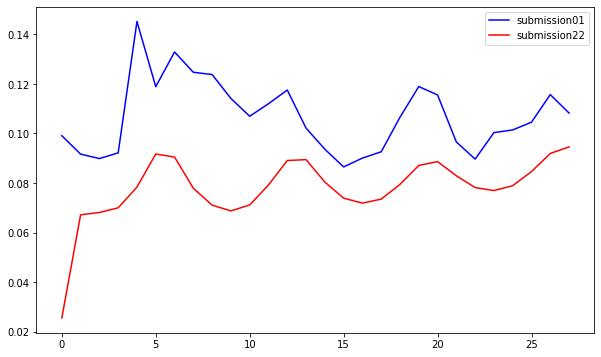

In [30]:
    plt.figure(figsize=(10,6))
    
    filter_id = "HOBBIES_2_003_CA_1_validation"
    filter_id = "HOBBIES_2_003_CA_2_validation"
    filter_id = "FOODS_2_003_CA_1_validation"
    filter_id = "HOUSEHOLD_2_010_WI_3_validation"
    pd.Series(res11[res11.id==filter_id].values[0,1:]).plot(linewidth=1.5, c='b')
    pd.Series(res22[res22.id==filter_id].values[0,1:]).plot(linewidth=1.5, c='r')


    
    plt.legend(["submission01","submission22"])